# Revolving Door data challenge

You belong to the people analytics team for a food conglomerate. Employee turnover has been rampant for your 10 subsidiaries. The CFO estimates that the cost of replacing an employee is often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months.
Your team has been tasked with diagnosing why and when employees from your subsidiaries leave. You need a tangible data-driven recommendation for each of the ten Presidents of your subsidiaries. What are your recommendations and why?

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    classes = [classes[ix] for ix in [0,1]]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.grid(False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                   fontsize = 20 )
    fig.tight_layout()
    return ax

# 1. Import and examine the data

In [37]:
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, roc_curve,roc_auc_score, auc, \
                            precision_score, recall_score, f1_score

In [5]:
sns.set(style="whitegrid", rc={
            'figure.figsize': (15, 7),
            'axes.titlesize': 24,
            'axes.labelsize': 20,
            'xtick.labelsize': 16,
            'ytick.labelsize': 16})

In [6]:
#df[['join_date', 'quit_date', 'days_tot', 'quit']]

In [7]:
df = pd.read_csv('Data/employee_retention_data.csv')

#remove outliers
df = df[df['seniority']<50]
df = df[df['seniority']<50]

df['join_date'] = pd.to_datetime(df['join_date'])
df['quit_date'] = pd.to_datetime(df['quit_date'])

df['quit_date'].max()-df['join_date'].min()

Timedelta('1780 days 00:00:00')

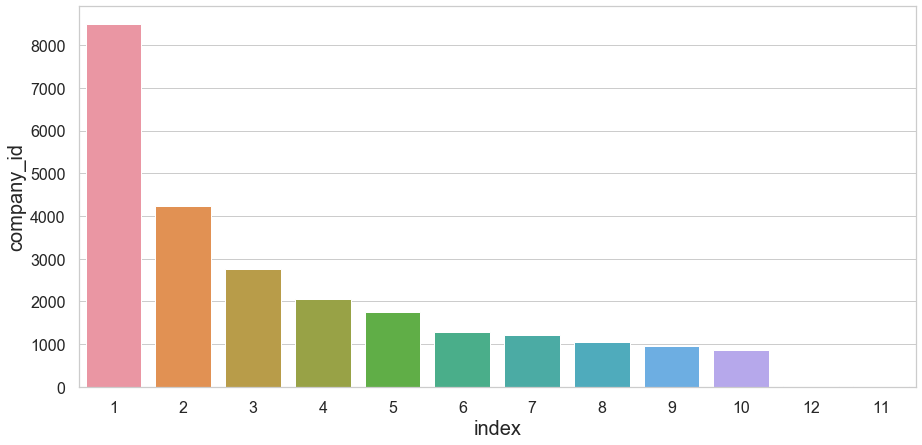

In [10]:
company_counts = df['company_id'].value_counts().sort_values(ascending = False).reset_index()
sns.barplot(x=company_counts['index'], y=company_counts.company_id, order =company_counts['index'] )

In [11]:
#remove companies with few counts
df = df[df['company_id']<=10]

In [12]:
#pandas profiling
profile = df.profile_report(title='employee_retention_data.csv Profiling Report')
profile.to_file(output_file="employee_retention_data_report.html")

### Generate features
- 'days_tot' - total days worked, NaN if the employee did not quit
- 'quit' - whether the employee quit the job within the given time period

In [13]:
df['days_tot'] = (df['quit_date']- df['join_date']).dt.days
df['quit'] = ~df['days_tot'].isnull()

### Total work period analysis
Turnover rate is consistent among the companies and professions. The observed peaks correspond to number of years worked, most people quit after the first year of work.

In [14]:
#approximately same number of quitters and non quitters in the dataset
df['days_tot'].isnull().value_counts()

False    13484
True     11176
Name: days_tot, dtype: int64

Text(0, 0.5, 'Counts')

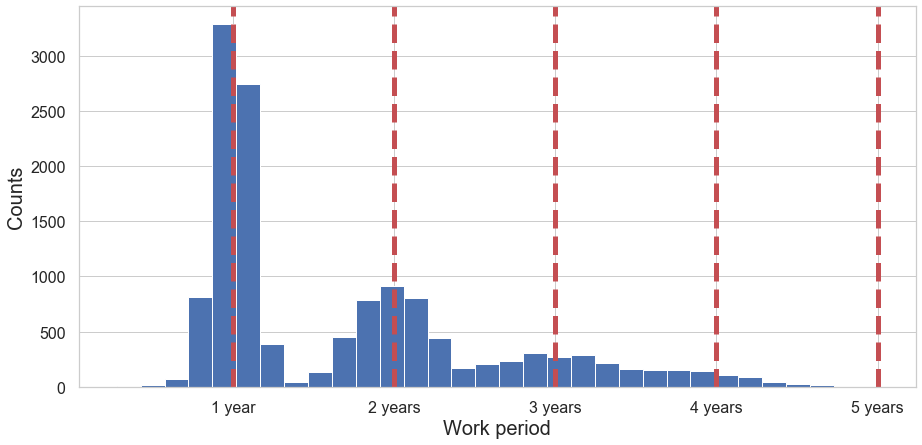

In [15]:
#Distribution of total days worked
# there seem to be several peaks in the data corresponding to number of years worked
fig, ax = plt.subplots(figsize = (15,7))


df['days_tot'].dropna().hist(bins = 30)

xticks = []
xlabels  = []
for i in range(1,6):
    xtick = 365*i
    plt.axvline(xtick, linewidth = 5,color='r', ls='--', alpha=1)
    xticks.append(xtick) 
    xlabels.append(str(i)+' years')


# plt.axvline(365*1.5, linewidth = 3,color='b', ls='--', alpha=1)
# plt.axvline(365*3.5, linewidth = 3,color='b', ls='--', alpha=1)


xlabels[0] = xlabels[0][:-1] #years -> year
plt.xticks(xticks, xlabels) # rotation='vertical'

plt.xlabel('Work period')
plt.ylabel('Counts')

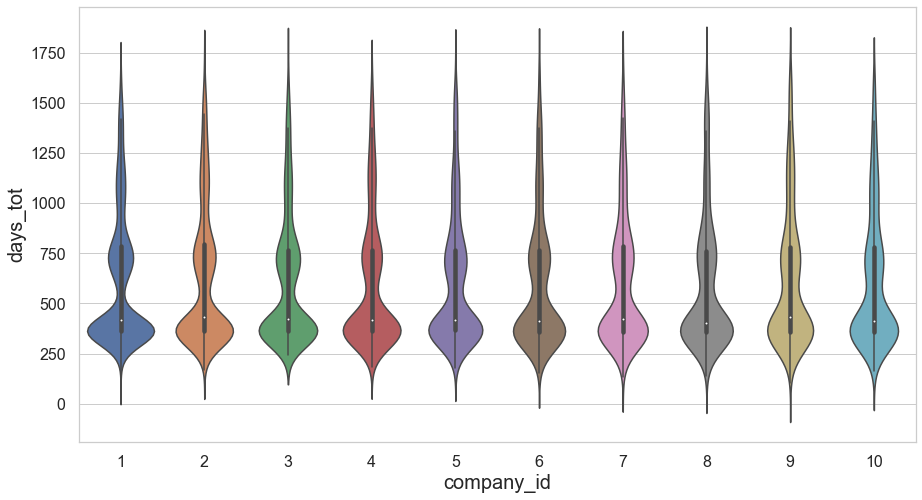

In [286]:
#days_tot vs company_id, no significant difference
ax = sns.violinplot(x="company_id", y="days_tot", data=df)

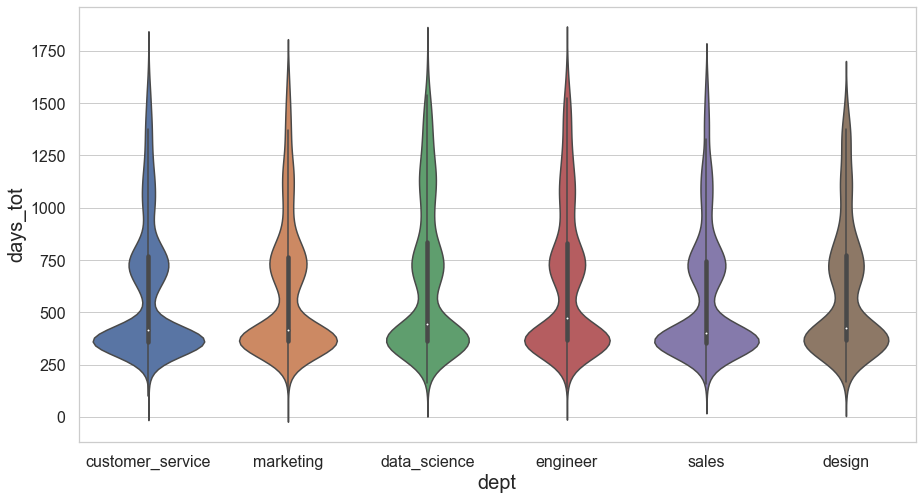

In [125]:
#days_tot vs dept, pretty consistent
ax = sns.violinplot(x="dept", y="days_tot", data=df)

## Salary and age impact

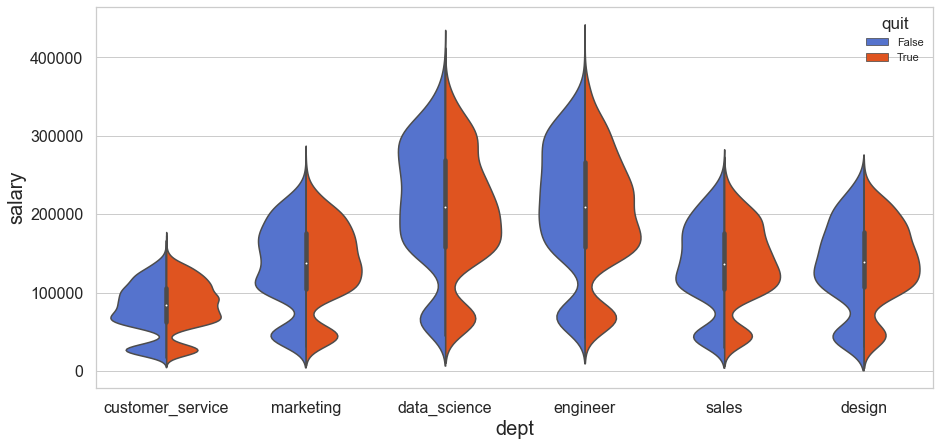

In [16]:
ax = sns.violinplot(x="dept", y="salary", hue = 'quit',split = True, data=df, inner = 'box', 
                    palette = ['royalblue', 'orangered'])

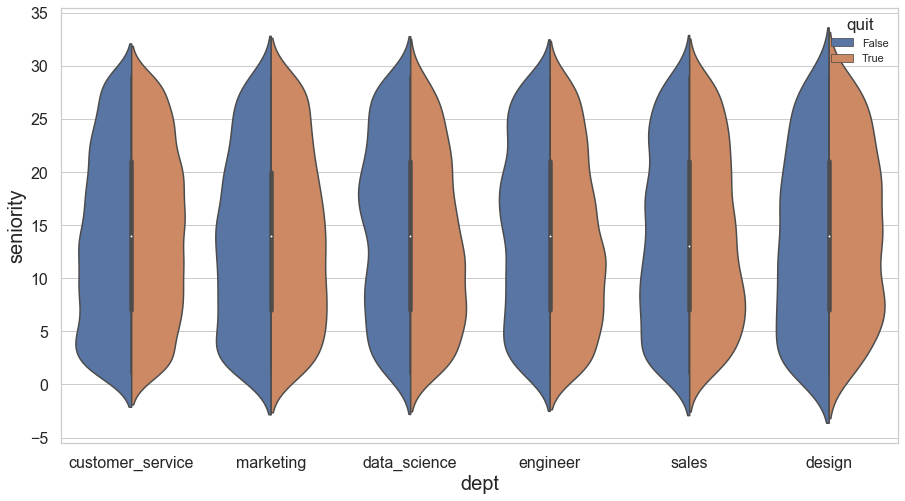

In [317]:
ax = sns.violinplot(x="dept", y="seniority", hue = 'quit',split = True, data=df)

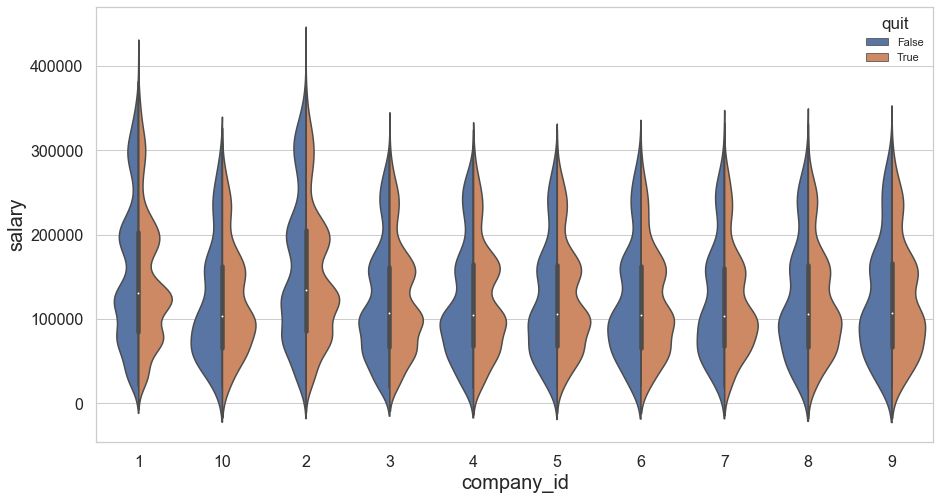

In [237]:
ax = sns.violinplot(x="company_id", y="salary", hue = 'quit',split = True, data=df)

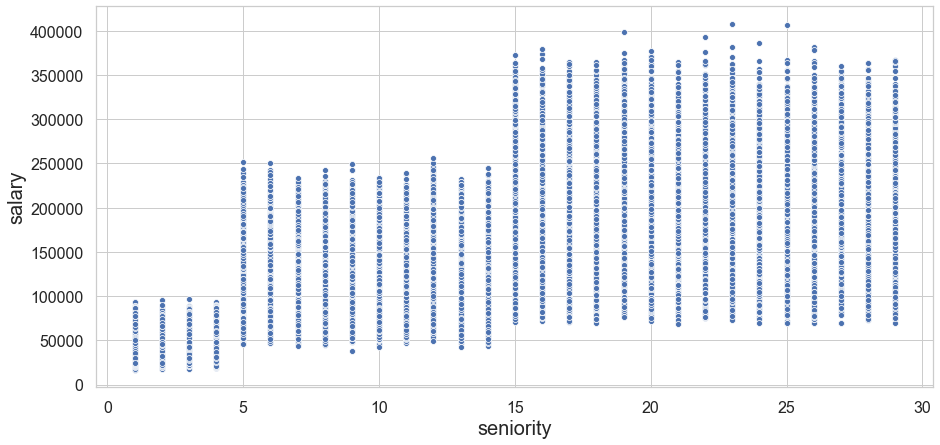

In [39]:
ax = sns.scatterplot(x="seniority", y="salary", data=df)

# Logistic regression! 
Build a simple classifier predicting whether an employee will quit within 1780 days period or not. Analyzing feature importance of the classifier will give some insights on how to reduce the turnover.

## Continious features

In [363]:
df['company_id'] = df['company_id'].apply(str)
df['log_salary']= np.log1p(df['salary'])

features =  ['seniority', 'log_salary',  'dept', 'company_id'] #,
target   =  'quit'

#mask = df['company_id'] == '1'

In [364]:
# X = pd.get_dummies(df[mask][features])
# y = df[mask][target].astype(int)

X = pd.get_dummies(df[features])
y = df[target].astype(int)


feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=666)

scaler = preprocessing.StandardScaler().fit(X_train)
clf = LogisticRegression(random_state=0, solver='lbfgs',).fit(
    scaler.transform(X_train), y_train)
    #X_train, y_train)

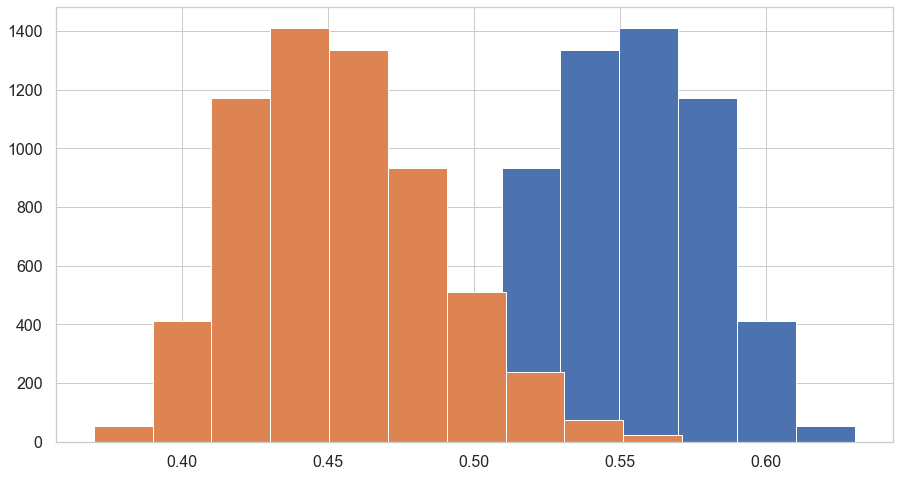

In [366]:
proba = clf.predict_proba(scaler.transform(X_test))

pd.Series(proba[:,1]).hist()
pd.Series(proba[:,0]).hist()

In [400]:
y_pred = clf.predict(scaler.transform(X_test))
cm = confusion_matrix(y_test, y_pred)

Normalized confusion matrix
[[0.2816092 0.7183908]
 [0.2224194 0.7775806]]


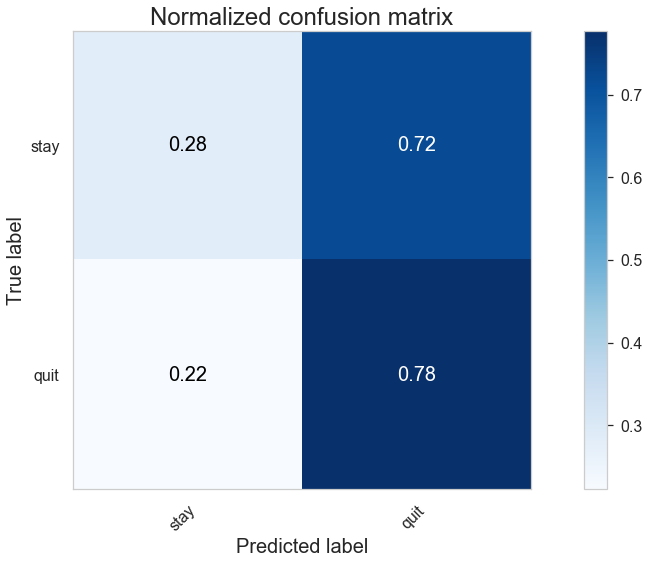

In [428]:
plot_confusion_matrix(y_test.values, y_pred, classes = ['stay', 'quit'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

In [368]:
pd.Series(index = list(feature_names), data = clf.coef_[0]).sort_values()

dept_engineer           -0.102305
seniority               -0.081536
company_id_2            -0.057699
dept_data_science       -0.048007
company_id_1            -0.017590
company_id_10           -0.002166
company_id_9            -0.002114
company_id_8             0.001066
company_id_6             0.003158
company_id_4             0.018829
dept_design              0.019214
company_id_5             0.027570
company_id_7             0.027725
dept_sales               0.029035
dept_marketing           0.029553
company_id_3             0.037198
dept_customer_service    0.066110
log_salary               0.145568
dtype: float64

In [369]:
import numpy as np
from sklearn.metrics import roc_curve,roc_auc_score, auc

fpr, tpr, thresholds = roc_curve(y_test.values, proba[:,1], pos_label=1)
auc(fpr, tpr)

0.5172540217986246

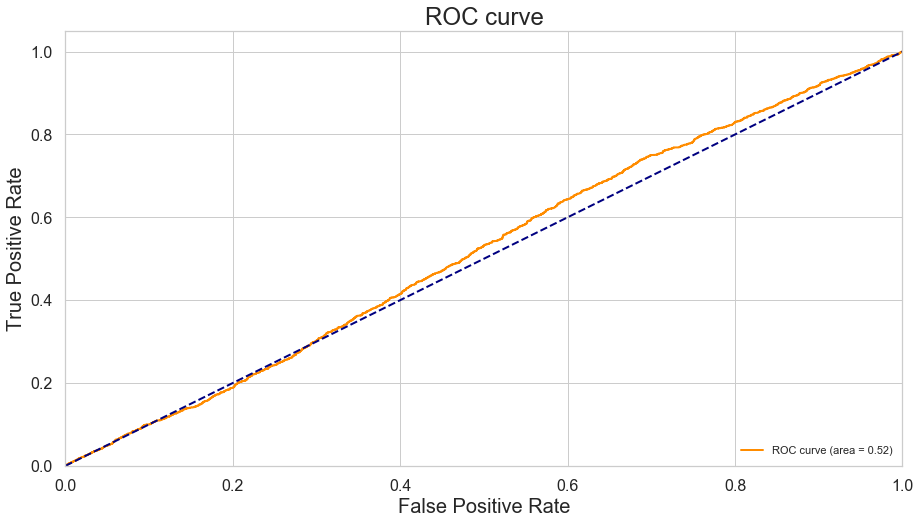

In [331]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

## Salary - dep interaction

In [18]:
df['salary_cat'] = df.groupby(['dept', 'company_id'])['salary'].apply(lambda sub_df:
        pd.qcut(sub_df, 4,
               labels=["salary_1q","salary_2q", "salary_3q", "salary_4q"]))

df['dept_salary'] = df['dept']+' '+df['salary_cat'].astype(str)

In [48]:
#df.groupby('dept_salary')['quit'].value_counts().sort_index().to_frame()

### Logistic regression based on the interaction feature

In [49]:
features =  ['dept_salary']
target   =  'quit'

#mask = df['company_id'] == '1'

In [50]:
X = pd.get_dummies(df[features])
y = df[target].astype(int)

feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=666)

#scaler = preprocessing.StandardScaler().fit(X_train)
clf = LogisticRegression(random_state=0, solver='lbfgs',).fit(
    X_train, y_train)
    #X_train, y_train)

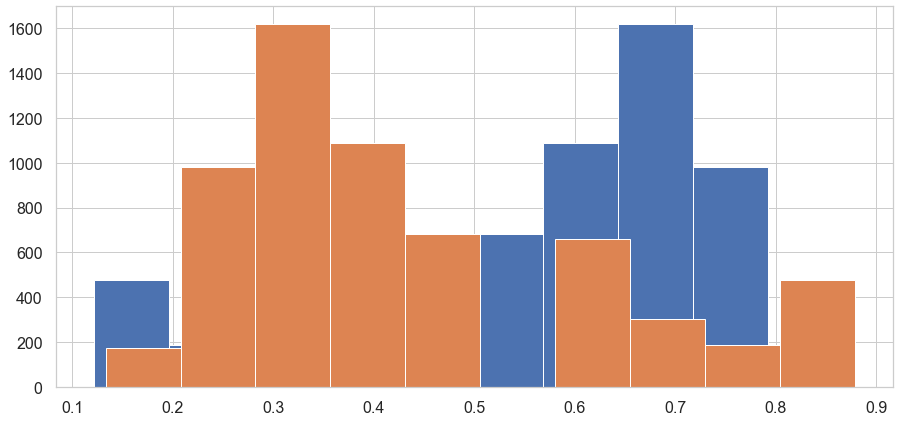

In [51]:
proba = clf.predict_proba(scaler.transform(X_test))

pd.Series(proba[:,1]).hist()
pd.Series(proba[:,0]).hist()

Normalized confusion matrix
[[0.29777299 0.70222701]
 [0.23632062 0.76367938]]


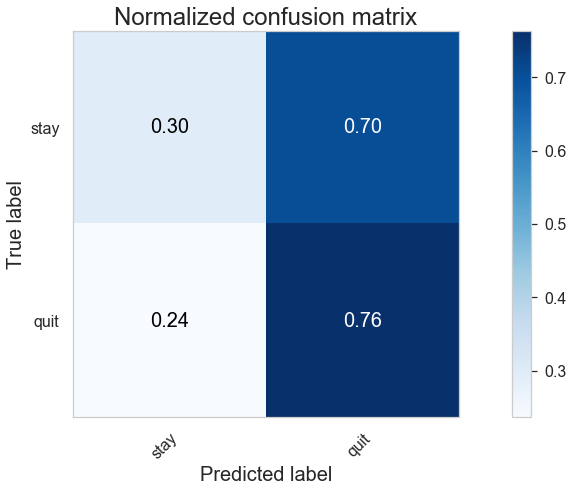

In [52]:
y_pred = clf.predict(scaler.transform(X_test))

plot_confusion_matrix(y_test.values, y_pred, classes = ['stay', 'quit'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

In [53]:
print(recall_score(y_test.values, y_pred),
      precision_score(y_test.values, y_pred),
     f1_score(y_test.values, y_pred))

0.7636793847973972 0.569098523253251 0.6521848951755493


Normalized confusion matrix
[[0.2816092 0.7183908]
 [0.2224194 0.7775806]]


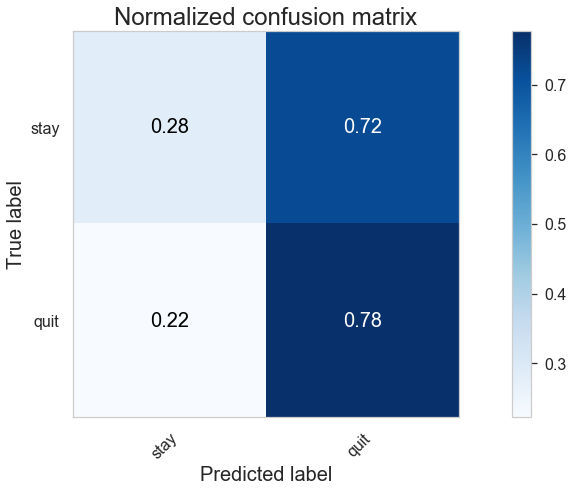

In [25]:
y_pred = clf.predict(scaler.transform(X_test))

plot_confusion_matrix(y_test.values, y_pred, classes = ['stay', 'quit'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

In [26]:
pd.Series(index = [feature[len('dept_salary_'):] for feature in feature_names], 
          data = clf.coef_[0]).sort_values()[-5:].to_frame()

,0
sales salary_3q,0.028259
sales salary_2q,0.031712
data_science salary_1q,0.036077
customer_service salary_3q,0.037549
customer_service salary_4q,0.047653


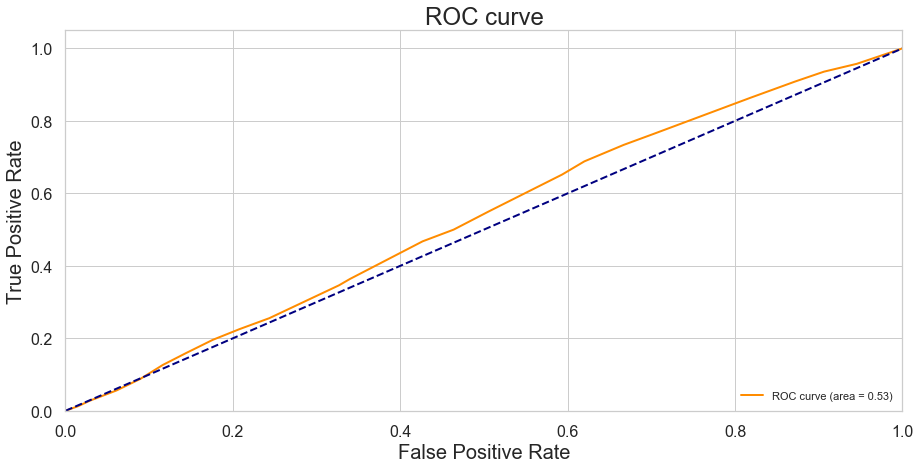

In [47]:
fpr, tpr, thresholds = roc_curve(y_test.values, proba[:,1], pos_label=1)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### XGBOOST

In [40]:
import xgboost as xgb

In [41]:
features =  ['dept_salary']
target   =  'quit'

#mask = df['company_id'] == '1'

In [62]:
X = pd.get_dummies(df[features])
y = df[target].astype(int)

feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=666)

clf = xgb.XGBClassifier().fit(X_train, y_train)

In [63]:
proba = clf.predict_proba(X_test)

In [64]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 784, 2000],
       [ 752, 2629]])

Normalized confusion matrix
[[0.2816092 0.7183908]
 [0.2224194 0.7775806]]


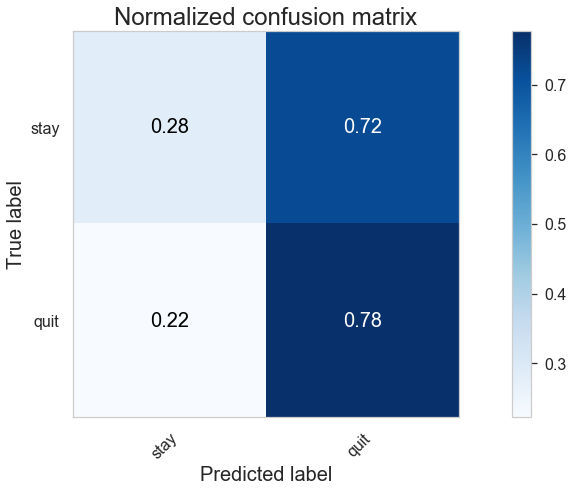

In [65]:
y_pred = clf.predict(X_test)

plot_confusion_matrix(y_test.values, y_pred, classes = ['stay', 'quit'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

In [67]:
print(recall_score(y_test.values, y_pred),
      precision_score(y_test.values, y_pred),
     f1_score(y_test.values, y_pred))

0.7775805974563739 0.5679412400086412 0.6564294631710362


In [66]:
fpr, tpr, thresholds = roc_curve(y_test.values, proba[:,1], pos_label=1)
auc(fpr, tpr)

0.5334159025929212

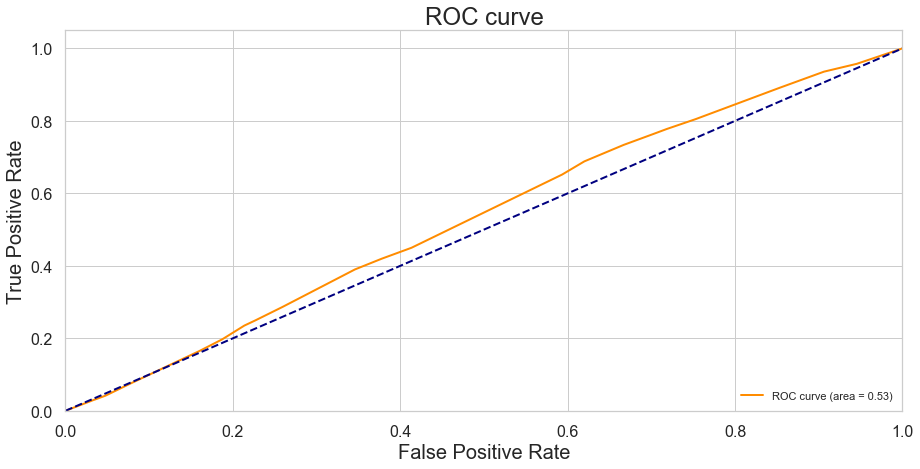

In [59]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()